In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares as ls

%matplotlib inline
mpl.rcParams['figure.dpi']=75
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Arial'})

In [12]:
def monopH(t,y, *args):
    # unpack parameters
    K_inv = args[0]
    pref = args[1]
    Sigma_inv = args[2]
    delta = args[3]
    gamma = args[4]
    mu_max = args[5]
    
    # unpack variables
    od = y[0]
    pH = y[1]
    
    # coupled ODE for cells and environmental pH
    dod = od * (mu_max - K_inv * od) * (np.exp2(-Sigma_inv * (pH - pref)**2.) - delta) 
    dpH = (gamma * dod) * (pH * (1. - pH / 14.))
    
    
    return [dod, dpH]  



In [13]:
# import data
pHdf = pd.ExcelFile('Data/All_pH.xlsx')
ODdf = pd.ExcelFile('Data/All_OD.xlsx')

# define experimental conditions and model parameter names
allpH = [4,5,6,7,8,9]
allspecies = ['AC','BA','BC','BL','BT','BV','CC','DF','wt','delarc','parc-','parc+']
allparam = ['K','pref','sigma','delta','gamma','mu']

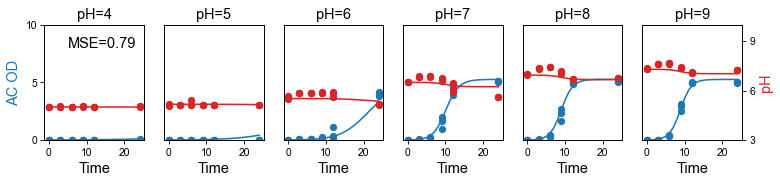

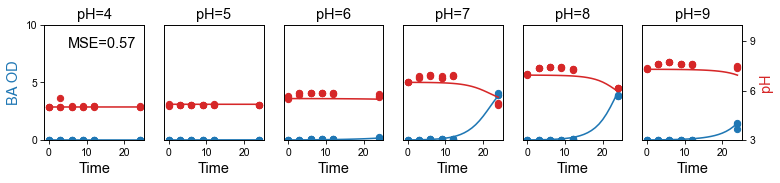

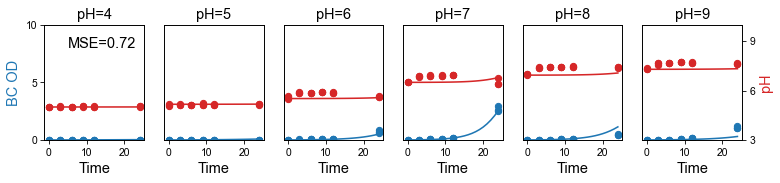

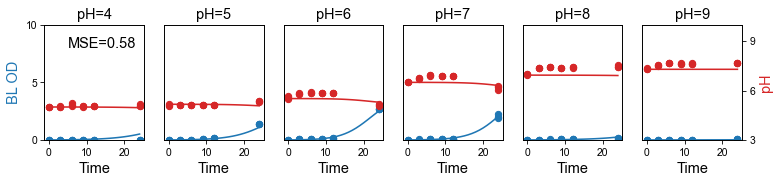

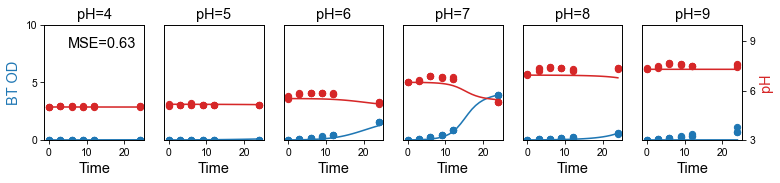

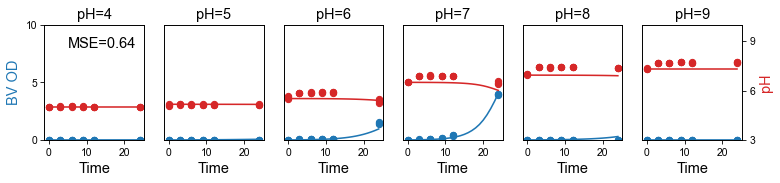

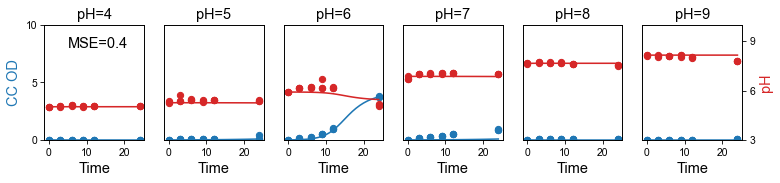

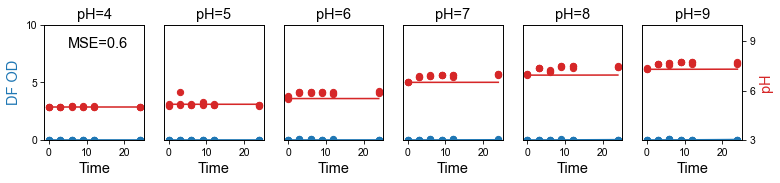

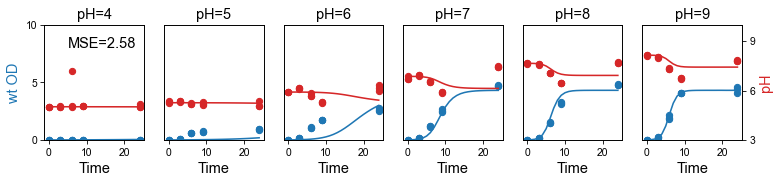

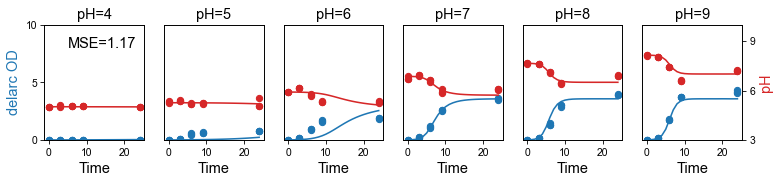

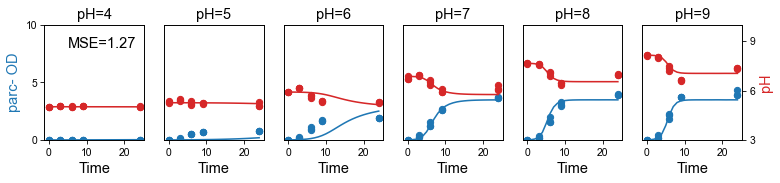

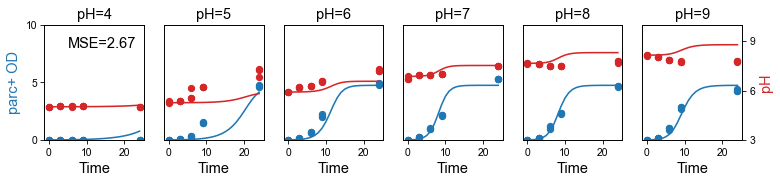

In [14]:
sim_t=np.linspace(0,24,25)
allspecies = ['AC','BA','BC','BL','BT','BV','CC','DF','wt','delarc','parc-','parc+']
allparam = ['K','pref','sigma','delta','gamma','mu']
AllstartpH=[5.00323233, 5.16809693, 5.51368636, 6.49630633, 6.93393392, 7.28735678]
masterDF=pd.read_csv('Fitting/param_by_species.csv')

for species in allspecies:
    fitted_params=[]
    for i in range(len(allparam)):
        fitted_params.append(masterDF[allparam[i]][allspecies.index(species)])

    speciesDF = pd.read_excel(ODdf,species)
    AllMin=[]
    exp_OD=[]
    exp_t = list(speciesDF['Time'])    
    avg_OD=[]


    for j in range(6):
        Min=min(min(speciesDF[str(allpH[j])+'_1']),min(speciesDF[str(allpH[j])+'_2']),min(speciesDF[str(allpH[j])+'_3']))
        AllMin.append(speciesDF[str(allpH[j])+'_'+str(1)][0]-Min+0.01)
        average_OD=[(a+b+c)/3 for a,b,c in zip(np.array(speciesDF[str(allpH[j])+'_'+str(1)])-Min+0.01,np.array(speciesDF[str(allpH[j])+'_'+str(2)])-Min+0.01,np.array(speciesDF[str(allpH[j])+'_'+str(3)])-Min+0.01)]
        avg_OD.extend(average_OD)
        for i in range(3):
            exp_OD.append(np.array(speciesDF[str(allpH[j])+'_'+str(i+1)])-Min+0.01)

    pHspeciesDF = pd.read_excel(pHdf,species)
    exp_Hplus=[]
    exp_pH=[]
    AllstartpH=[]
    avg_pH=[]

    for j in range(6):
        AllstartpH.append(pHspeciesDF[str(allpH[j])+'_1'][0])
        average_pH=[(a+b+c)/3 for a,b,c in zip(np.array(pHspeciesDF[str(allpH[j])+'_'+str(1)]),np.array(pHspeciesDF[str(allpH[j])+'_'+str(2)]),np.array(pHspeciesDF[str(allpH[j])+'_'+str(3)]))]
        avg_pH.extend(average_pH)
        for i in range(3):
            exp_pH.append(np.array(pHspeciesDF[str(allpH[j])+'_'+str(i+1)]))


    fig,ax=plt.subplots(1,6,figsize=(12,2))
    MSE = 0
    for j in range(6):

        sim_P=solve_ivp(monopH, t_span=[0,24],y0=[AllMin[j],AllstartpH[j]],t_eval=sim_t,args = fitted_params)
        sim_OD=sim_P.y[0]
        sim_pH=sim_P.y[1]

        ax[j].plot(sim_t,sim_OD,color='tab:blue')
        for rep in range(3):
            ax[j].scatter(exp_t,list(exp_OD[:][j*3+rep]),color='tab:blue')
        ax[j].set_ylim([0,10])
        ax[j].set_xlabel('Time',fontsize=14)
        ax[j].set_yticks([])


        ax2=ax[j].twinx()
        ax2.plot(sim_t,sim_pH,color='tab:red')
        for rep in range(3):
            ax2.scatter(exp_t,list(exp_pH[:][j*3+rep]),color='tab:red')
        ax2.set_ylim([3,10])
        ax2.set_yticks([])

        ax[j].set_title('pH='+str(allpH[j]),fontsize=14)

        sim_P=solve_ivp(monopH, t_span=[0,24],y0=[AllMin[j],AllstartpH[j]],t_eval=exp_t,args = fitted_params)
        sim_OD=sim_P.y[0]
        sim_pH=sim_P.y[1]
        for rep in range(3):
            MSE += sum([(a-b)**2/len(exp_t)/3 for a,b in zip(exp_OD[:][j*3+rep],sim_OD)])
            MSE += sum([(a-b)**2/len(exp_t)/3 for a,b in zip(exp_pH[:][j*3+rep],sim_pH)])

    ax[0].text(5,8,'MSE='+str(round(MSE,2)), fontsize=14)


    ax[0].set_yticks([0,5,10])
    ax[0].set_ylabel(species+' OD',color='tab:blue',fontsize=14)
    ax2.set_yticks([3,6,9])
    ax2.set_ylabel('pH',color='tab:red',fontsize=14)
    ax[0].set_ylabel(species+' OD',color='tab:blue',fontsize=14)

    plt.savefig('Figures/'+species+'_prediction.svg') 